In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
# import seaborn as sns

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [11]:
# replace contents of exptdata.exptdict
for ekey in list(exptdata.exptdict.keys()):
    del exptdata.exptdict[ekey]

for ekey in ['1deg_jra55_iaf_control', '1deg_jra55_iaf_test_yearp1', '1deg_jra55_iaf_test_yearp1_qv56', '1deg_jra55_iaf_test_yearp1_qv56_2']:
    exptdata.exptdict[ekey] = dict()
    e = exptdata.exptdict[ekey]
    e['model'] = 'access-om2'
    e['expt'] = 'input4MIPs_testing_'+ekey
    e['desc'] = ekey
    e['exptdir'] = '/g/data/hh5/tmp/cosima/access-om2/'+e['expt']
    e['time_units'] = None
    e['offset'] = None
    

In [19]:
exptdata.exptdict

OrderedDict([('1deg_jra55_iaf_control',
              {'model': 'access-om2',
               'expt': 'input4MIPs_testing_1deg_jra55_iaf_control',
               'desc': '1deg_jra55_iaf_control',
               'exptdir': '/g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_control',
               'time_units': None,
               'offset': None,
               'variables': OrderedDict([('temp_global_ave',
                             <xarray.DataArray 'temp_global_ave' (time: 60, scalar_axis: 1)>
                             dask.array<shape=(60, 1), dtype=float64, chunksize=(1, 1)>
                             Coordinates:
                               * time         (time) object 1958-01-16 12:00:00 ... 1962-12-16 12:00:00
                               * scalar_axis  (scalar_axis) float64 0.0
                             Attributes:
                                 long_name:      Global mean temp in liquid seawater
                                 units:         

In [13]:
figdir = ''
def savefigure(fname):
#     plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [16]:
def load_data(variable):
    for ekey in exptdata.exptdict.keys():
        e = exptdata.exptdict[ekey]
        if 'variables' not in e:
            e['variables'] = OrderedDict.fromkeys('')
        if variable not in e['variables']:
            e['variables'][variable] = cc.get_nc_variable(e['expt'],'ocean_scalar.nc',
                                    variable,
                                    time_units=e['time_units'],offset=e['offset'])

In [21]:
variables = ['temp_global_ave', 'temp_surface_ave', 'salt_surface_ave', 'ke_tot']
for v in variables:
    load_data(v)

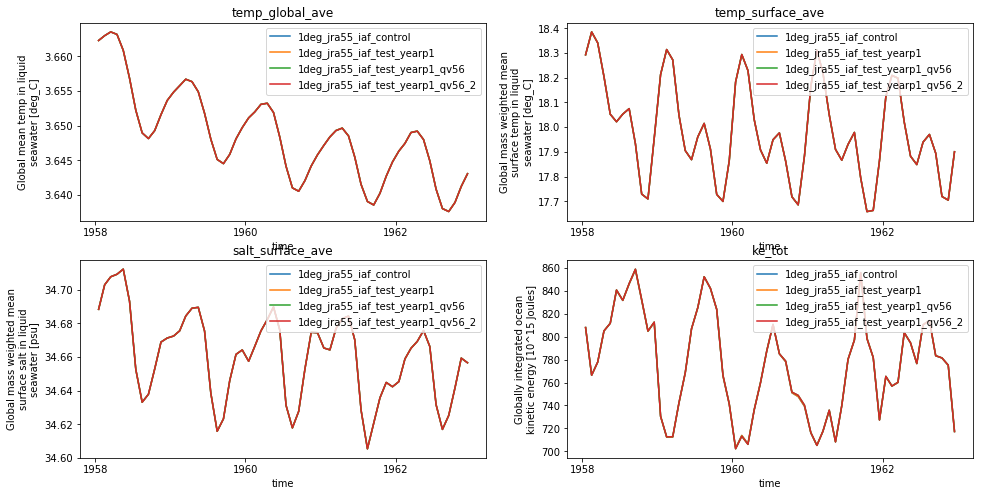

In [24]:
plt.figure(figsize=(16,8))
for i,v in enumerate(variables):
    for ekey in exptdata.exptdict.keys():
        e = exptdata.exptdict[ekey]
        ax = plt.subplot(2,2,i+1)
        e['variables'][v].plot(label=e['desc'])
        plt.legend()
        plt.title(v)

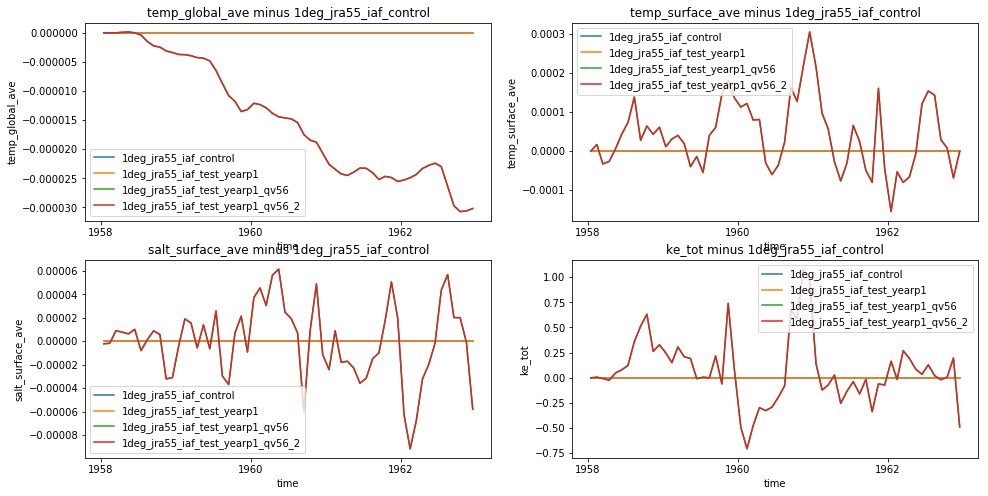

In [35]:
plt.figure(figsize=(16,8))
ref = '1deg_jra55_iaf_control'
# ref = '1deg_jra55_iaf_test_yearp1_qv56'
for i,v in enumerate(variables):
    for j,ekey in enumerate(exptdata.exptdict.keys()):
#         if j>1:
        e = exptdata.exptdict[ekey]
        ax = plt.subplot(2,2,i+1)
        data = e['variables'][v] - exptdata.exptdict[ref]['variables'][v]
        data.plot(label=e['desc'])
        plt.legend()
        plt.title(v+' minus '+ref)
#         if j==3:
#             break

# OLD STUFF BELOW

## To deal with memory issues (if needed):
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.0.64.16:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run e.g.:
`dask-worker tcp://10.0.64.16:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/aek156` (with the appropriate changes to the adderss and local directory)
* Then, make sure the following cell matches the scheduler address.

In [41]:
def global_scalar(variable):
    for ekey in exptdata.exptdict.keys():
        e = exptdata.exptdict[ekey]
#         expt = exptdata.exptdict[ekey]['expt']
#         time_units = exptdata.exptdict[ekey]['time_units']
#         offset = exptdata.exptdict[ekey]['offset']
        darray = cc.get_nc_variable(e['expt'],'ocean_scalar.nc',
                                    variable,
                                    time_units=e['time_units'],offset=e['offset'])
        darray.plot(label=e['desc'])
        annual_average = darray.resample(time='A').mean()
#         annual_average.plot(label=e['desc'])

    plt.gca().autoscale()

In [35]:
def add_cycles():
    pass

#     cycle_dates = [1778, 1838, 1898]
#     ylims=plt.gca().get_ylim()
#     for cd in cycle_dates:
#         plt.plot([pd.datetime(cd,1,1),pd.datetime(cd,1,1)],ylims,'k--',linewidth=0.8)
#     plt.gca().set_ylim(ylims)

In [5]:
temp=np.loadtxt('aravg.ann.ocean.90S.90N.v4.0.1.201901.asc')
#sst_year = temp[:,0]
#sst_year = sst_year.astype('datetime64')
#for i,year in enumerate(sst_year):
#    print(i, year)
#    sst_year[i] = pd.datetime(year.astype(int),7,1)
sst = temp[:,1] + 18
sst_year = pd.date_range(start='1880-07-01',freq='A',periods=sst.size)
sst_year

DatetimeIndex(['1880-12-31', '1881-12-31', '1882-12-31', '1883-12-31',
               '1884-12-31', '1885-12-31', '1886-12-31', '1887-12-31',
               '1888-12-31', '1889-12-31',
               ...
               '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31',
               '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31',
               '2018-12-31', '2019-12-31'],
              dtype='datetime64[ns]', length=140, freq='A-DEC')

In [ ]:
ax=plt.subplot(111)
global_scalar('temp_surface_ave')
plt.xlabel('')
plt.ylabel('')
ax.set_title('(b) Global average sea surface temperature',position=(0.0,1.0))
ax.set_xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
ax.set_xticks([pd.datetime(1965,1,1), pd.datetime(1975,1,1), pd.datetime(1985,1,1)], minor=True)

ax.plot(sst_year,sst,'k--')
#plt.xlim([1958,2018])

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/protocol/core.py", line 192, in loads_msgpack
    decompress = compressions[header['compression']]['decompress']
KeyError: 'snappy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/protocol/core.py", line 109, in loads
    msg = loads_msgpack(small_header, small_payload)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/protocol/core.py", line 196, in loads_msgpack
    " installed" % str(header['compression']))
ValueError: Data is compressed as snappy but we don't have this installed
distributed.utils - ERROR - Data is compressed as snappy but we don't have this installed
Trac

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cook

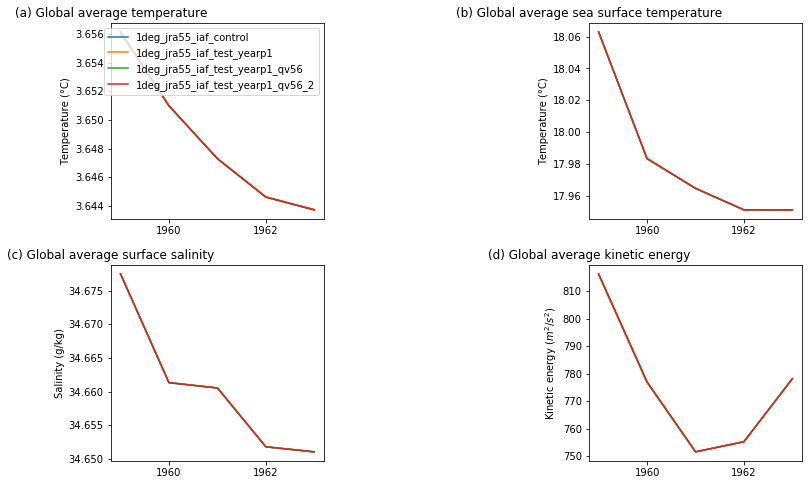

In [38]:
# %%time
plt.figure(figsize=(16,8))

#############
## FIRST PLOT
ax = plt.axes([0.125, 0.545,0.185, 0.34])
global_scalar('temp_global_ave')
plt.legend()
plt.xlabel('')
plt.ylabel('Temperature (°C)')
# ax.set_ylim([3.45, 3.9])
# ax.set_xlim([pd.datetime(1718,1,1),pd.datetime(1957,12,31)])
# ax.set_xticks([pd.datetime(1730,1,1), pd.datetime(1740,1,1), pd.datetime(1750,1,1), pd.datetime(1770,1,1), 
#                pd.datetime(1780,1,1), pd.datetime(1790,1,1), pd.datetime(1810,1,1), pd.datetime(1820,1,1), 
#                pd.datetime(1830,1,1), pd.datetime(1850,1,1), pd.datetime(1860,1,1), pd.datetime(1870,1,1),
#                pd.datetime(1890,1,1), pd.datetime(1900,1,1), pd.datetime(1910,1,1), pd.datetime(1930,1,1),
#                pd.datetime(1940,1,1), pd.datetime(1950,1,1)], minor=True)
# add_cycles()

# ax = plt.axes([0.31, 0.545,0.185, 0.34])
# ax.set_yticks([])
# global_scalar('temp_global_ave')
# plt.xlabel('')
# plt.ylabel('')
ax.set_title('(a) Global average temperature',position=(0.0,1.0))
# ax.set_ylim([3.45, 3.9])
# ax.set_xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])

##############
## SECOND PLOT
ax = plt.axes([0.54, 0.545,0.185, 0.34])
global_scalar('temp_surface_ave')
plt.xlabel('')
plt.ylabel('Temperature (°C)')
# ax.set_ylim([17.65, 18.6])
# ax.set_xlim([pd.datetime(1718,1,1),pd.datetime(1957,12,31)])
# ax.set_xticks([pd.datetime(1730,1,1), pd.datetime(1740,1,1), pd.datetime(1750,1,1), pd.datetime(1770,1,1), 
#                pd.datetime(1780,1,1), pd.datetime(1790,1,1), pd.datetime(1810,1,1), pd.datetime(1820,1,1), 
#                pd.datetime(1830,1,1), pd.datetime(1850,1,1), pd.datetime(1860,1,1), pd.datetime(1870,1,1),
#                pd.datetime(1890,1,1), pd.datetime(1900,1,1), pd.datetime(1910,1,1), pd.datetime(1930,1,1),
#                pd.datetime(1940,1,1), pd.datetime(1950,1,1)], minor=True)
# add_cycles()

# ax = plt.axes([0.725, 0.545,0.185, 0.34])
# ax.set_yticks([])
# global_scalar('temp_surface_ave')
# plt.xlabel('')
# plt.ylabel('')
ax.set_title('(b) Global average sea surface temperature',position=(0.0,1.0))
# ax.set_xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
# ## Add Obs:
# ax.plot(sst_year,sst,'k--')
# ax.set_ylim([17.65, 18.6])


#############
## THIRD PLOT
ax = plt.axes([0.125, 0.125,0.185, 0.34])
global_scalar('salt_surface_ave')
plt.xlabel('')
plt.ylabel('Salinity (g/kg)')
# ax.set_ylim([34.43, 34.77])
# ax.set_xlim([pd.datetime(1718,1,1),pd.datetime(1957,12,31)])
# ax.set_xticks([pd.datetime(1730,1,1), pd.datetime(1740,1,1), pd.datetime(1750,1,1), pd.datetime(1770,1,1), 
#                pd.datetime(1780,1,1), pd.datetime(1790,1,1), pd.datetime(1810,1,1), pd.datetime(1820,1,1), 
#                pd.datetime(1830,1,1), pd.datetime(1850,1,1), pd.datetime(1860,1,1), pd.datetime(1870,1,1),
#                pd.datetime(1890,1,1), pd.datetime(1900,1,1), pd.datetime(1910,1,1), pd.datetime(1930,1,1),
#                pd.datetime(1940,1,1), pd.datetime(1950,1,1)], minor=True)
# add_cycles()

# ax = plt.axes([0.31, 0.125,0.185, 0.34])
# ax.set_yticks([])
# global_scalar('salt_surface_ave')
# plt.ylabel('')
ax.set_title('(c) Global average surface salinity',position=(0.0,1.0))
# ax.set_xlabel('Year',position=(0.0,1.0))
# ax.set_ylim([34.43, 34.77])
# ax.set_xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])

#############
## FOURTH PLOT
ax = plt.axes([0.54, 0.125,0.185, 0.34])
global_scalar('ke_tot')
plt.xlabel('')
plt.ylabel('Kinetic energy ($m^2/s^2$)')
# ax.set_ylim([0, 3600])
# ax.set_xlim([pd.datetime(1718,1,1),pd.datetime(1957,12,31)])
# ax.set_xticks([pd.datetime(1730,1,1), pd.datetime(1740,1,1), pd.datetime(1750,1,1), pd.datetime(1770,1,1), 
#                pd.datetime(1780,1,1), pd.datetime(1790,1,1), pd.datetime(1810,1,1), pd.datetime(1820,1,1), 
#                pd.datetime(1830,1,1), pd.datetime(1850,1,1), pd.datetime(1860,1,1), pd.datetime(1870,1,1),
#                pd.datetime(1890,1,1), pd.datetime(1900,1,1), pd.datetime(1910,1,1), pd.datetime(1930,1,1),
#                pd.datetime(1940,1,1), pd.datetime(1950,1,1)], minor=True)
# add_cycles()

# ax = plt.axes([0.725, 0.125,0.185, 0.34])
# ax.set_yticks([])
# global_scalar('ke_tot')
# plt.ylabel('')
ax.set_title('(d) Global average kinetic energy',position=(0.0,1.0))
# ax.set_xlabel('Year',position=(0.0,1.0))
# ax.set_ylim([0, 3600])
# ax.set_xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])

savefigure('GlobalTimeseries')

# plotting initial salt change due to ice adjustment 

In [6]:
exptdata.exptdict['1deg']

{'model': 'access-om2',
 'expt': '1deg_jra55v13_iaf_spinup1_B1',
 'desc': 'ACCESS-OM2',
 'n_files': -12,
 'time_units': 'days since 1718-01-01',
 'offset': -87658,
 'exptdir': '/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1'}

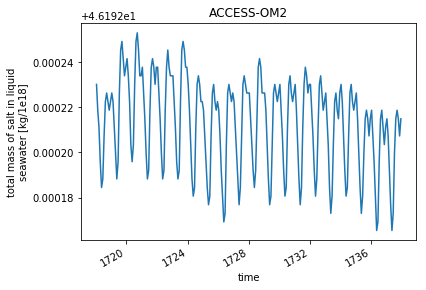

In [24]:
e = exptdata.exptdict['1deg']

total_ocean_salt = cc.get_nc_variable(e['expt'],'ocean_scalar.nc','total_ocean_salt',
                                      time_units=e['time_units'],offset=e['offset'],
                                     n=4)

total_ocean_salt.plot()
plt.title(e['desc'])
savefigure('total_ocean_salt_'+e['desc'])

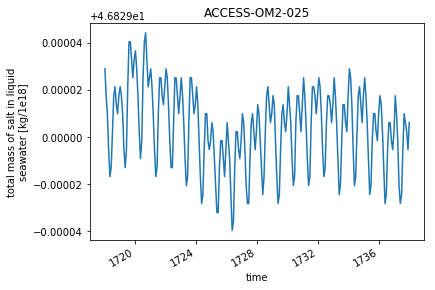

In [22]:
e = exptdata.exptdict['025deg']
total_ocean_salt_025 = cc.get_nc_variable(e['expt'],'ocean_scalar.nc','total_ocean_salt',
                                      time_units=e['time_units'],offset=e['offset'],
                                     n=10)

total_ocean_salt_025.plot()
plt.title(e['desc'])
savefigure('total_ocean_salt_'+e['desc'])

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


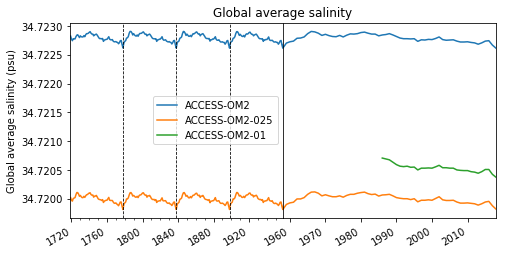

In [30]:
plt.figure(figsize=(16,8))

ax = plt.axes([0.125, 0.545,0.185, 0.34])
global_scalar('salt_global_ave')
plt.legend()
plt.xlabel('')
plt.ylabel('Global average salinity (psu)')
# ax.set_ylim([3.45, 3.9])
ax.set_xlim([pd.datetime(1718,1,1),pd.datetime(1957,12,31)])
ax.set_xticks([pd.datetime(1730,1,1), pd.datetime(1740,1,1), pd.datetime(1750,1,1), pd.datetime(1770,1,1), 
               pd.datetime(1780,1,1), pd.datetime(1790,1,1), pd.datetime(1810,1,1), pd.datetime(1820,1,1), 
               pd.datetime(1830,1,1), pd.datetime(1850,1,1), pd.datetime(1860,1,1), pd.datetime(1870,1,1),
               pd.datetime(1890,1,1), pd.datetime(1900,1,1), pd.datetime(1910,1,1), pd.datetime(1930,1,1),
               pd.datetime(1940,1,1), pd.datetime(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.31, 0.545,0.185, 0.34])
ax.set_yticks([])
global_scalar('salt_global_ave')
plt.xlabel('')
plt.ylabel('')
ax.set_title('Global average salinity',position=(0.0,1.0))
# ax.set_ylim([3.45, 3.9])
ax.set_xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])

savefigure('salt_global_ave')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


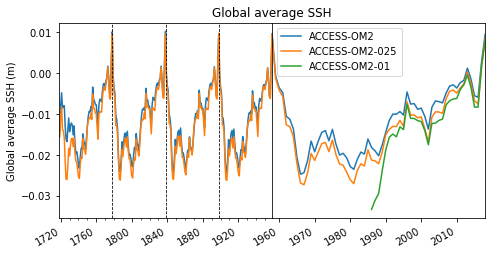

In [31]:
plt.figure(figsize=(16,8))

ax = plt.axes([0.125, 0.545,0.185, 0.34])
global_scalar('eta_global')
plt.xlabel('')
plt.ylabel('Global average SSH (m)')
# ax.set_ylim([3.45, 3.9])
ax.set_xlim([pd.datetime(1718,1,1),pd.datetime(1957,12,31)])
ax.set_xticks([pd.datetime(1730,1,1), pd.datetime(1740,1,1), pd.datetime(1750,1,1), pd.datetime(1770,1,1), 
               pd.datetime(1780,1,1), pd.datetime(1790,1,1), pd.datetime(1810,1,1), pd.datetime(1820,1,1), 
               pd.datetime(1830,1,1), pd.datetime(1850,1,1), pd.datetime(1860,1,1), pd.datetime(1870,1,1),
               pd.datetime(1890,1,1), pd.datetime(1900,1,1), pd.datetime(1910,1,1), pd.datetime(1930,1,1),
               pd.datetime(1940,1,1), pd.datetime(1950,1,1)], minor=True)
add_cycles()

ax = plt.axes([0.31, 0.545,0.185, 0.34])
ax.set_yticks([])
global_scalar('eta_global')
plt.legend()
plt.xlabel('')
plt.ylabel('')
ax.set_title('Global average SSH',position=(0.0,1.0))
# ax.set_ylim([3.45, 3.9])
ax.set_xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
savefigure('eta_global')